# SULPHUR DIOXIDE (SO2)

In [4]:
%%capture
!pip install xarray==0.20.2  #latest package 2022.6.0 doesn't work
!pip install s3fs
!pip install netcdf4
!pip install h5netcdf

!pip install geopandas --quiet
!pip install shapely --quiet
!pip install contextily --quiet

In [5]:
import s3fs
import h5netcdf
import netCDF4
import xarray as xr

import pandas as pd
import numpy as np
import boto3
import matplotlib.pyplot as plt
import math

from shapely.geometry import Point, Polygon
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
import contextily as cx

### LOOP THROUGH FOLDERS AND EXTRACT DATA

In [6]:
one_to_nine = ['01', '02', '03', '04', '05', '06', '07', '08', '09']
ten_to_32 = list(range(10, 32))
for i in ten_to_32:
    i = str(i)
ten_to_32_str = [str(i) for i in ten_to_32]
subfolder_list = one_to_nine + ten_to_32_str
print(subfolder_list)

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']


In [7]:
#reduce down to only looking at half a month
limit = math.ceil(len(subfolder_list)/2)
subfolder_list = subfolder_list[0:limit]
print(subfolder_list)

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16']


In [10]:
indices = [5, 6, 7, 8]   #take only keys at these indices from each subfolder, where we know london coverage appears
keys = []
for i in subfolder_list:
    bucket = 'meeo-s5p'
    subfolder = 'OFFL/L2__SO2___/2022/06/' + i + '/'   #loop through June's subfolders

    conn = boto3.client('s3')
    #some folders e.g. 10 don't exist, continue loop when error for these non existent folders
    try:
        contents = conn.list_objects(Bucket=bucket, Prefix=subfolder)['Contents']
    except:
        continue
    
    temp_list = []
    for f in contents:
        temp_list.append(f['Key'])
    
    for index in range(len(temp_list)):
        if index in indices:
            keys.append(temp_list[index])
            
keys[0:4]

['OFFL/L2__SO2___/2022/06/01/S5P_OFFL_L2__SO2____20220601T085512_20220601T103642_24005_02_020300_20220603T135420.nc',
 'OFFL/L2__SO2___/2022/06/01/S5P_OFFL_L2__SO2____20220601T103642_20220601T121812_24006_02_020300_20220603T140503.nc',
 'OFFL/L2__SO2___/2022/06/01/S5P_OFFL_L2__SO2____20220601T121812_20220601T135942_24007_02_020300_20220603T100758.nc',
 'OFFL/L2__SO2___/2022/06/01/S5P_OFFL_L2__SO2____20220601T135942_20220601T154112_24008_02_020300_20220603T113927.nc']

In [21]:
len(keys)

61

In [22]:
#find .nc file where filtering does not result in 0 longitude or latitudes (or co)

uk_keys = []
count = 0
uk_df = pd.DataFrame() 
for i in keys:
    #extract data from netcdf5 as xarray dataset
    fs = s3fs.S3FileSystem(anon=True)
    f = fs.open('s3://meeo-s5p/' + i)
    ds = xr.open_dataset(f, engine='h5netcdf', group = 'PRODUCT')

    #collapse 3 dimensions
    ds = ds.sel(time=ds.time[0])
    ds = ds.sel(layer=0)
    ds = ds.drop_dims('corner')
    #only high quality data
    #ds = ds.where(ds.qa_value > 0.5, drop = True)
    #target parameter
    ds = ds[['latitude', 'longitude', 'sulfurdioxide_total_vertical_column', 'qa_value']]   #keep qa value too, can filter later if want
    #uk filter
    #ds = ds.where((ds.latitude > 50.10319) & (ds.latitude < 60.15456), drop = True)
    #ds = ds.where((ds.longitude > -7.64133) & (ds.longitude < 1.75159), drop = True)
    #london filter
    ds = ds.where((ds.latitude > 51.239405) & (ds.latitude < 51.737184), drop = True)
    ds = ds.where((ds.longitude > -0.625211) & (ds.longitude < 0.328289), drop = True)

    #drop nas along remaining dimensions - NO, for transparency of method, NAs will be dropped from dataframe than xarray
    #ds = ds.dropna('scanline', how='any')
    #ds = ds.dropna('ground_pixel', how='any')
    
    count += 1
    
    df = ds.to_dataframe()
    df = df.reset_index()
    df = df.drop(['scanline', 'ground_pixel'], axis = 1)
    df = df.dropna(how = 'any')
    
    if len(df) == 0:
        print(str(count) + '/' + str(len(keys)), '\t', '---> NONE FOUND')
        continue
    else:
        print(str(count) + '/' + str(len(keys)), '\t', '---> UK COVERAGE FOUND')
        #append to uk keys list
        uk_keys.append(i)
        #append to uk dataframe
        uk_df = uk_df.append(df)
        continue

1/61 	 ---> NONE FOUND
2/61 	 ---> UK COVERAGE FOUND
3/61 	 ---> UK COVERAGE FOUND
4/61 	 ---> NONE FOUND
5/61 	 ---> NONE FOUND
6/61 	 ---> NONE FOUND
7/61 	 ---> UK COVERAGE FOUND
8/61 	 ---> NONE FOUND
9/61 	 ---> NONE FOUND
10/61 	 ---> UK COVERAGE FOUND
11/61 	 ---> NONE FOUND
12/61 	 ---> NONE FOUND
13/61 	 ---> NONE FOUND
14/61 	 ---> UK COVERAGE FOUND
15/61 	 ---> UK COVERAGE FOUND
16/61 	 ---> NONE FOUND
17/61 	 ---> NONE FOUND
18/61 	 ---> UK COVERAGE FOUND
19/61 	 ---> UK COVERAGE FOUND
20/61 	 ---> NONE FOUND
21/61 	 ---> NONE FOUND
22/61 	 ---> UK COVERAGE FOUND
23/61 	 ---> UK COVERAGE FOUND
24/61 	 ---> NONE FOUND
25/61 	 ---> NONE FOUND
26/61 	 ---> UK COVERAGE FOUND
27/61 	 ---> UK COVERAGE FOUND
28/61 	 ---> NONE FOUND
29/61 	 ---> NONE FOUND
30/61 	 ---> UK COVERAGE FOUND
31/61 	 ---> NONE FOUND
32/61 	 ---> NONE FOUND
33/61 	 ---> NONE FOUND
34/61 	 ---> UK COVERAGE FOUND
35/61 	 ---> UK COVERAGE FOUND
36/61 	 ---> NONE FOUND
37/61 	 ---> NONE FOUND
38/61 	 ---> NON

In [23]:
uk_df.head()

,latitude,longitude,sulfurdioxide_total_vertical_column,qa_value,time,layer
4,51.259598,0.292720,0.000067,0.21,2022-06-01,0
11,51.303303,0.252288,-0.000607,0.20,2022-06-01,0
17,51.271698,0.059670,0.000053,0.21,2022-06-01,0
18,51.346848,0.211568,0.000078,0.20,2022-06-01,0
24,51.315163,0.018826,-0.000365,0.20,2022-06-01,0


In [24]:
len(uk_df)

2508

In [25]:
#persist dataframe to local csv file        
uk_df.to_csv('so2_sentinel_01-16june.csv', index = False)

### MANUAL EDA OF DATA FOR METRIC (e.g. setup filters needed)

In [4]:
fs = s3fs.S3FileSystem(anon=True)

# Open with s3fs
f = fs.open('s3://meeo-s5p/OFFL/L2__SO2___/2022/01/01/S5P_OFFL_L2__SO2____20220101T105540_20220101T123710_21864_02_020201_20220103T084819.nc')

# open xarray dataset
ds2 = xr.open_dataset(f, engine='h5netcdf', group = 'PRODUCT')   #or netcdf4

In [25]:
ds5 = ds2.copy()

In [26]:
ds5

<xarray.Dataset>
Dimensions:                                        (scanline: 4172, ground_pixel: 450, time: 1, corner: 4, layer: 34)
Coordinates:
  * scanline                                       (scanline) float64 0.0 ......
  * ground_pixel                                   (ground_pixel) float64 0.0...
  * time                                           (time) datetime64[ns] 2022...
  * corner                                         (corner) float64 0.0 ... 3.0
  * layer                                          (layer) int32 0 1 2 ... 32 33
Data variables:
    latitude                                       (time, scanline, ground_pixel) float32 ...
    longitude                                      (time, scanline, ground_pixel) float32 ...
    delta_time                                     (time, scanline, ground_pixel) datetime64[ns] ...
    time_utc                                       (time, scanline) object ...
    qa_value                                       (time, scanline, ground_pixel) float32 ...
    sulfurdioxide_total_vertical_column            (time, scanline, ground_pixel) float32 ...
    sulfurdioxide_total_vertical_column_precision  (time, scanline, ground_pixel) float32 ...

In [27]:
print(ds5.latitude.size)
print(ds5.longitude.size)

1877400
1877400


In [28]:
#filtering to 1 time essentially drops time dimension
ds5 = ds5.sel(time=ds5.time[0])

In [29]:
print(ds5.latitude.size)
print(ds5.longitude.size)

1877400
1877400


In [30]:
ds5 = ds5.sel(layer=0)

In [31]:
print(ds5.latitude.size)
print(ds5.longitude.size)

1877400
1877400


In [32]:
#only need scanline and ground_pixel dimensions for lon lat and co (see brackets)
ds5 = ds5.drop_dims('corner')

In [33]:
print(ds5.latitude.size)
print(ds5.longitude.size)

1877400
1877400


In [38]:
ds5

<xarray.Dataset>
Dimensions:                                        (scanline: 4172, ground_pixel: 450)
Coordinates:
  * scanline                                       (scanline) float64 0.0 ......
  * ground_pixel                                   (ground_pixel) float64 0.0...
    time                                           datetime64[ns] 2022-01-01
    layer                                          int32 0
Data variables:
    latitude                                       (scanline, ground_pixel) float32 ...
    longitude                                      (scanline, ground_pixel) float32 ...
    delta_time                                     (scanline, ground_pixel) datetime64[ns] ...
    time_utc                                       (scanline) object nan ... nan
    qa_value                                       (scanline, ground_pixel) float32 ...
    sulfurdioxide_total_vertical_column            (scanline, ground_pixel) float32 ...
    sulfurdioxide_total_vertical_column_precision  (scanline, ground_pixel) float32 ...

In [35]:
#Recommend to ignore data with qa_value < 0.5 --> from data variable descriptor
#ds5 = ds5.where(ds5.qa_value > 0.5, drop = True)

In [36]:
print(ds5.latitude.size)
ds5.longitude.size

1877400


1877400

In [39]:
#uk filter latitude, 500m is the lowest of the 50 layers
#ds5 = ds5.where((ds5.latitude > 50.10319) & (ds5.latitude < 60.15456), drop = True)
#ds5 = ds5.where((ds5.longitude > -7.64133) & (ds5.longitude < 1.75159), drop = True)

#london filter
ds5 = ds5.where((ds5.latitude > 51.239405) & (ds5.latitude < 51.737184), drop = True)
ds5 = ds5.where((ds5.longitude > -0.625211) & (ds5.longitude < 0.328289), drop = True)

In [40]:
print(ds5.latitude.size)
ds5.longitude.size

168


168

In [542]:
#BEST DROPPING NAS FROM DATAFRAME RATHER THAN XARRAY AS CLEARER WHATS BEING DONE

#drops NAs in this dimension
#will remove all NAs of co

#how ({"any", "all"}, default: "any") –
#any : if any NA values are present, drop that label
#all : if all values are NA, drop that label

#if any of longitude, latitude or co have null values, that data record becomes useless, so drop any

#ds5 = ds5.dropna('scanline', how='any')
#ds5 = ds5.dropna('ground_pixel', how='any')

In [41]:
ds5

<xarray.Dataset>
Dimensions:                                        (scanline: 14, ground_pixel: 12)
Coordinates:
  * scanline                                       (scanline) float64 3.609e+...
  * ground_pixel                                   (ground_pixel) float64 74....
    time                                           datetime64[ns] 2022-01-01
    layer                                          int32 0
Data variables:
    latitude                                       (scanline, ground_pixel) float32 ...
    longitude                                      (scanline, ground_pixel) float32 ...
    delta_time                                     (scanline, ground_pixel) datetime64[ns] ...
    time_utc                                       (scanline, ground_pixel) object ...
    qa_value                                       (scanline, ground_pixel) float32 ...
    sulfurdioxide_total_vertical_column            (scanline, ground_pixel) float32 ...
    sulfurdioxide_total_vertical_column_precision  (scanline, ground_pixel) float32 ...

In [42]:
df = ds5.to_dataframe()

In [43]:
df.head()

latitude  longitude delta_time time_utc  qa_value  \
scanline ground_pixel                                                      
3609.0   74.0               NaN        NaN        NaT      NaN       NaN   
         75.0               NaN        NaN        NaT      NaN       NaN   
         76.0               NaN        NaN        NaT      NaN       NaN   
         77.0               NaN        NaN        NaT      NaN       NaN   
         78.0               NaN        NaN        NaT      NaN       NaN   

                       sulfurdioxide_total_vertical_column  \
scanline ground_pixel                                        
3609.0   74.0                                          NaN   
         75.0                                          NaN   
         76.0                                          NaN   
         77.0                                          NaN   
         78.0                                          NaN   

                       sulfurdioxide_total_vertical_column_precision  \
scanline ground_pixel                                                  
3609.0   74.0                                                    NaN   
         75.0                                                    NaN   
         76.0                                                    NaN   
         77.0                                                    NaN   
         78.0                                                    NaN   

                            time  layer  
scanline ground_pixel                    
3609.0   74.0         2022-01-01      0  
         75.0         2022-01-01      0  
         76.0         2022-01-01      0  
         77.0         2022-01-01      0  
         78.0         2022-01-01      0

In [44]:
len(df)

168

In [45]:
df = df.reset_index()

In [46]:
df.head()

,scanline,ground_pixel,latitude,longitude,delta_time,time_utc,qa_value,sulfurdioxide_total_vertical_column,sulfurdioxide_total_vertical_column_precision,time,layer
0,3609.0,74.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,2022-01-01,0
1,3609.0,75.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,2022-01-01,0
2,3609.0,76.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,2022-01-01,0
3,3609.0,77.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,2022-01-01,0
4,3609.0,78.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,2022-01-01,0


In [47]:
df.columns

Index(['scanline', 'ground_pixel', 'latitude', 'longitude', 'delta_time',
       'time_utc', 'qa_value', 'sulfurdioxide_total_vertical_column',
       'sulfurdioxide_total_vertical_column_precision', 'time', 'layer'],
      dtype='object')

In [49]:
df = df[['time', 'layer', 'latitude', 'longitude', 'sulfurdioxide_total_vertical_column', 'qa_value']]
df.head()

,time,layer,latitude,longitude,sulfurdioxide_total_vertical_column,qa_value
0,2022-01-01,0,NaN,NaN,NaN,NaN
1,2022-01-01,0,NaN,NaN,NaN,NaN
2,2022-01-01,0,NaN,NaN,NaN,NaN
3,2022-01-01,0,NaN,NaN,NaN,NaN
4,2022-01-01,0,NaN,NaN,NaN,NaN


In [50]:
print('Number of NAs:', df['sulfurdioxide_total_vertical_column'].isnull().sum())

Number of NAs: 68


In [51]:
df = df.dropna(how = 'any')

In [52]:
df.head()

,time,layer,latitude,longitude,sulfurdioxide_total_vertical_column,qa_value
7,2022-01-01,0,51.245838,0.211708,0.001446,0.00
8,2022-01-01,0,51.274513,0.290674,-0.004544,0.00
18,2022-01-01,0,51.263016,0.099561,0.013282,0.00
19,2022-01-01,0,51.292065,0.179176,0.000246,0.00
20,2022-01-01,0,51.320759,0.258201,0.001738,0.48


In [53]:
len(df)

100

In [54]:
df.duplicated().value_counts()

False    100
dtype: int64

### MAPPING LATITUDES AND LONGITUDES

In [26]:
df = uk_df

In [27]:
len(df)

2508

In [28]:
lalo_data = df[['longitude', 'latitude']]
lalo_data.head()

,longitude,latitude
4,0.292720,51.259598
11,0.252288,51.303303
17,0.059670,51.271698
18,0.211568,51.346848
24,0.018826,51.315163


In [29]:
london_map = gpd.read_file(r'London-wards-2018/London-wards-2018_ESRI/London_Ward_CityMerged.shp')

geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = gpd.GeoDataFrame(lalo_data, geometry = geometry, crs = 4326)
#4326 is the go to CRS for GPS lat lon, need to set here so conversion to another is standardised as setting wrong CRS here means conversion (to_crs) will be wrong

london_map['geometry'] = london_map['geometry'].to_crs(epsg=3857)
gdf['geometry'] = gdf['geometry'].to_crs(epsg=3857)

In [30]:
def makeLayeredMap(*args):
    """This function accepts an arbitrary number of geodataframes, plots them on top of a Contextily basemap. 
    NOTE: Please edit the Plotting-section to specify parameters for the number of layers and the formatting of each layer.
    Output: Saved file and layered map for display."""
    
    # Convert the CRS for all layers to EPSG3857 to match Contextily
    args = list(map(lambda x: x.to_crs(epsg=3857), args))
    # Create figure
    fig, ax = plt.subplots(1, figsize=(20, 20))
    #Set aspect to equal
    ax.set_aspect('equal')
    
    # PLOTTING: Specify layers to plot how to format each layer (colours, transparency, etc.):
    # Layer 1:
    args[0].boundary.plot(ax=ax, color='blue', edgecolor='k', alpha=0.3, zorder=1)
    # Layer 2:
    args[1].plot(ax=ax, color='red', markersize=400, marker='*', zorder=2)
    # ADD LAYERS here as needed:
    #args[2].plot(ax=ax, color='black', alpha=0.3, zorder=3)
    
    # Contextily basemap:
    cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
    
    # Turn off axis
    ax.axis('off')
    # Save as file
    fig.savefig('SO2_sentinel_london_satellite.png', dpi=300)
    layered_map = plt.show()
    return(layered_map)
    #plt.show()

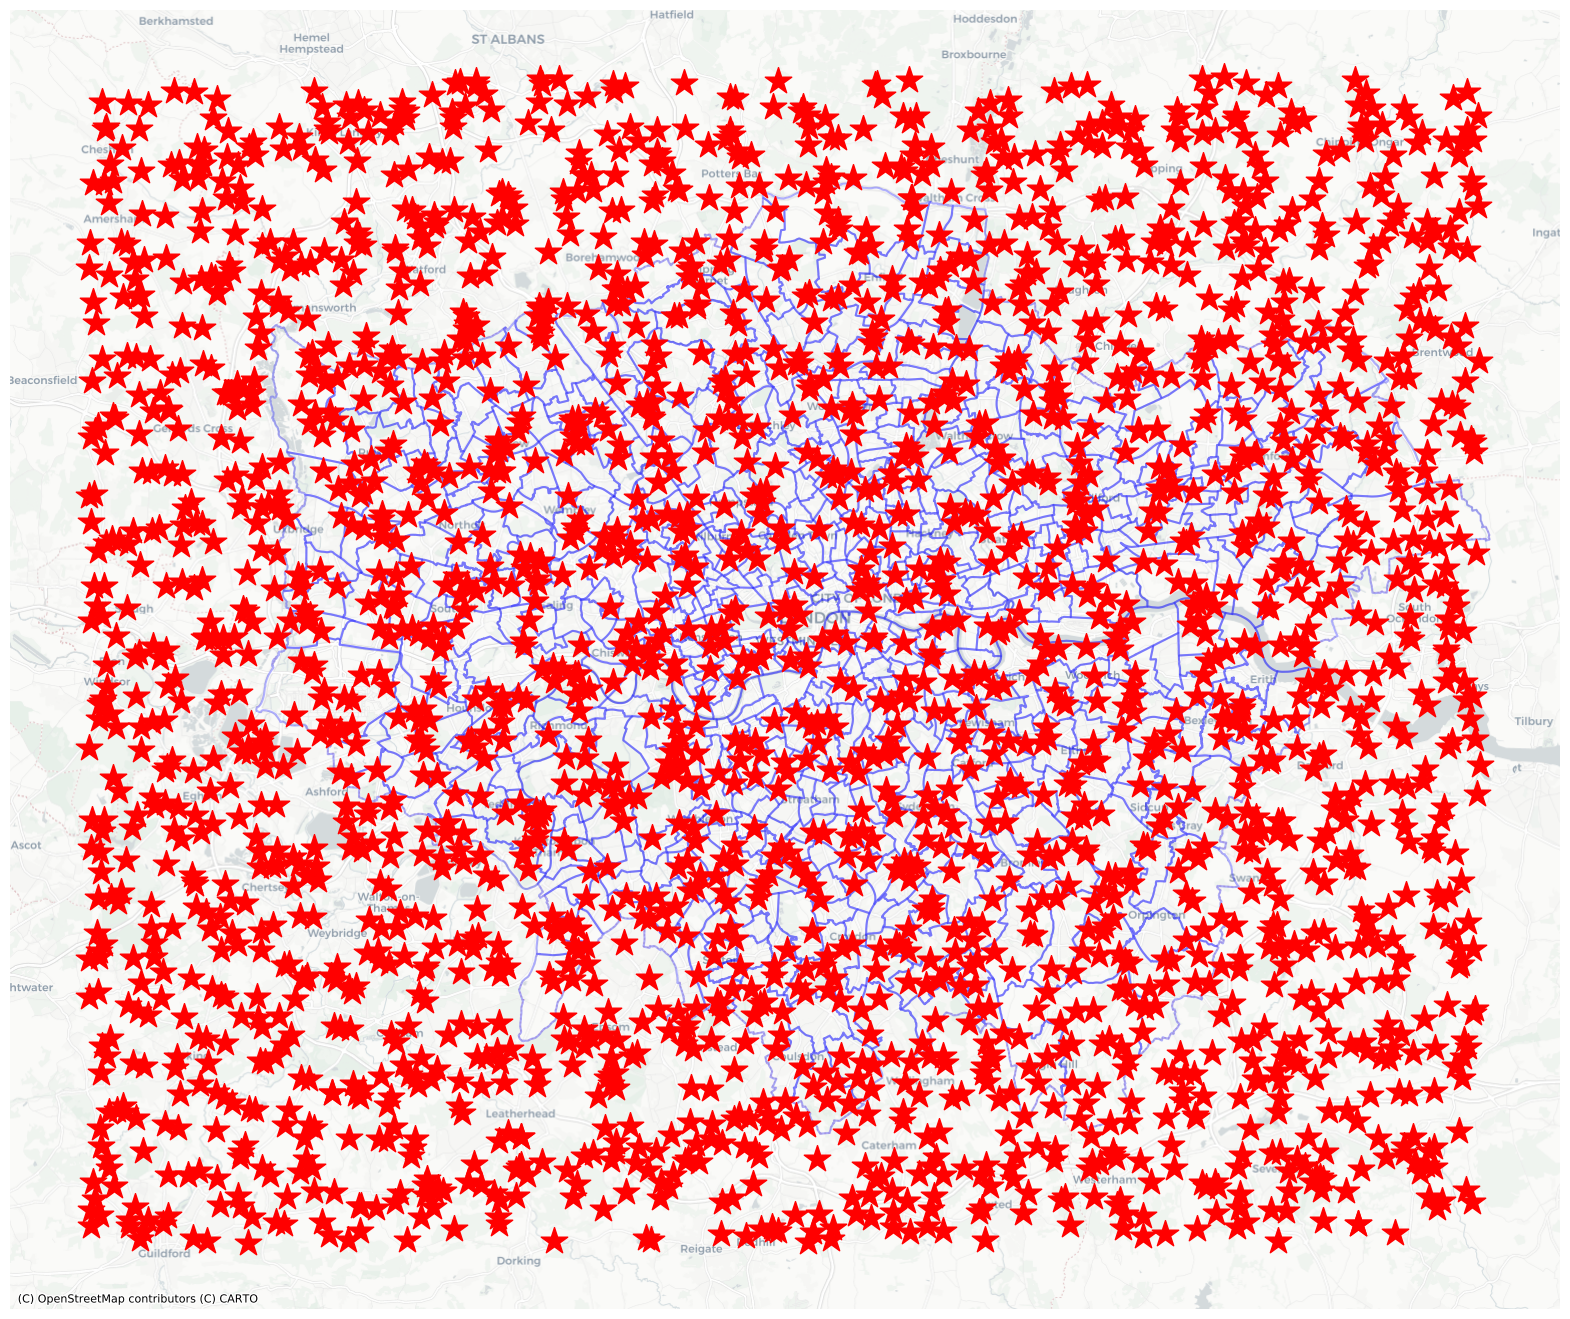

In [31]:
makeLayeredMap(london_map, gdf)